In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt

In [3]:
tf.__version__, tfp.__version__

('2.8.0', '0.15.0')

In [4]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#SCALE_FACTOR = 1
SCALE_FACTOR = 255

# Select binary data
label_sub = [0,1]
x_train_sub = [x.reshape(-1) / SCALE_FACTOR for x, y in zip(x_train, y_train) if y in label_sub]
y_train_sub = [y.reshape(-1) for y in y_train if y in label_sub]
x_test_sub = [x.reshape(-1) / SCALE_FACTOR for x, y in zip(x_test, y_test) if y in label_sub]
y_test_sub = [y.reshape(-1) for y in y_test if y in label_sub]


print('There are', len(x_train_sub), 'training images.')
print('There are', len(x_test_sub), 'test images.')

There are 12665 training images.
There are 2115 test images.


In [5]:
x_train_sub[0].min(), x_train_sub[0].max()

(0.0, 1.0)

In [6]:
# x_train_sub = x_train_sub[:100]
# y_train_sub = y_train_sub[:100]

print('There are', len(x_train_sub), 'training images.')

There are 12665 training images.


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_sub, y_test_sub)).batch(32)

In [8]:
# # Standard BP
# model_bp = keras.Sequential(
#     [
#         keras.Input(shape=(784,)),
#         layers.Dense(32, activation = "sigmoid"),
#         layers.Dense(1, activation = "sigmoid")
#     ]
# )

# batch_size = 32
# epochs = 200
# #opt = tf.keras.optimizers.SGD(learning_rate=.1)
# opt = tf.keras.optimizers.Adam(learning_rate=.01)
# st = time.time()
# model_bp.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "AUC"])
# history = model_bp.fit(train_ds, batch_size=batch_size, epochs=epochs)
# print(time.time() - st)

In [9]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]    
    return t

def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)

In [53]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        
        #initializer = initializers.RandomUniform(minval=-0.001, maxval=0.001, seed=None)
        #l1_initializer = initializers.RandomUniform(minval=-0.001 * 255, maxval=0.001 * 255, seed=None)
        #self.fc_layers = [Dense(layer_size, kernel_initializer=initializer) for layer_size in hidden_layer_sizes]
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        
        #self.output_layer = Dense(n_outputs, kernel_initializer=initializer)
        self.output_layer = Dense(n_outputs)
    
    
    def call_stochastic(self, x, inpainting=False, x_mask=None):
        
        if inpainting:
            self.num_missing = int(x_mask.reshape((-1, 784)).sum(axis=-1).mean())
            network = [tf.cast(np.zeros((len(x), self.num_missing)), dtype=tf.float32)]
        else:
            network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
        
        return network
    
    
    def call(self, x):

        for layer in self.fc_layers:
            x = tm.sigmoid(layer(x))
            
        return tm.sigmoid(self.output_layer(x))

    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            #print(cont_bern_log_norm(tf.nn.sigmoid(logits)))
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    
    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    
    def target_log_prob_inpainting(self, x, x_mask, h, y):

        h_current = [tf.nn.sigmoid(l) for l in tf.split(h, [self.num_missing] + self.hidden_layer_sizes, axis = 1)]
        
        #x_filled = tf.where(
        #    tf.cast(x_mask.reshape(-1, 784), dtype=tf.bool),
        #    h_current[0],
        #    tf.cast(x, dtype=tf.float32)
        #)

        x_filled = tf.cast(x, dtype=tf.float32)
        tf.tensor_scatter_nd_update(
            x_filled,
            tf.where(tf.cast(x_mask.reshape(-1, 28 * 28), dtype=tf.bool)),
            tf.reshape(h_current[0], (-1))
        )
        #x_filled[x_mask] = h_current[0]
        
        h_current = h_current[1:]
        h_previous = [x_filled] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    
    def generate_hmc_kernel_inpainting(self, x, x_mask, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob_inpainting(x, x_mask, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True, inpainting=False):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        if inpainting:
            h_new = tf.split(h_state, [self.num_missing] + self.hidden_layer_sizes, axis = 1)
        else:
            h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1)
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    
    def update_weights(self, x, h, y, lr = 0.0001):
        
        #optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    
    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels

In [54]:
model = StochasticMLP(hidden_layer_sizes = [32], n_outputs = 1)

In [55]:
# Train with backprop

batch_size = 32
epochs = 10
opt = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "AUC"])
history = model.fit(train_ds, batch_size=batch_size, epochs=epochs)

Epoch 1/10
396/396 [==============================] - 0s 572us/step - loss: 0.0650 - accuracy: 0.9916 - auc: 0.9995
Epoch 2/10
396/396 [==============================] - 0s 565us/step - loss: 0.0093 - accuracy: 0.9985 - auc: 1.0000
Epoch 3/10
396/396 [==============================] - 0s 554us/step - loss: 0.0054 - accuracy: 0.9991 - auc: 1.0000
Epoch 4/10
396/396 [==============================] - 0s 578us/step - loss: 0.0039 - accuracy: 0.9991 - auc: 1.0000
Epoch 5/10
396/396 [==============================] - 0s 544us/step - loss: 0.0031 - accuracy: 0.9992 - auc: 0.9999
Epoch 6/10
396/396 [==============================] - 0s 555us/step - loss: 0.0024 - accuracy: 0.9994 - auc: 0.9999
Epoch 7/10
396/396 [==============================] - 0s 583us/step - loss: 0.0019 - accuracy: 0.9996 - auc: 0.9999
Epoch 8/10
396/396 [==============================] - 0s 561us/step - loss: 0.0016 - accuracy: 0.9996 - auc: 0.9999
Epoch 9/10
396/396 [==============================] - 0s 553us/step - lo

In [64]:
x_mask = np.array([[[False] * 28] * 28] * 32)
x_mask[:, 11:17, 11:17] = True

In [65]:
for images, labels in train_ds:
    net = model.call_stochastic(images, inpainting=True, x_mask=x_mask)
    kernel = model.generate_hmc_kernel_inpainting(images, x_mask, labels)
    break

In [66]:
# Burn-in
burnin = 1000
newnet = net

for i in range(burnin):

    if(i % 100 == 0): print("Step %d" % i)
    
    newnet = model.propose_new_state_hamiltonian(
        images, newnet, labels, kernel,
        is_update_kernel=False,
        inpainting=True
    )

Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900


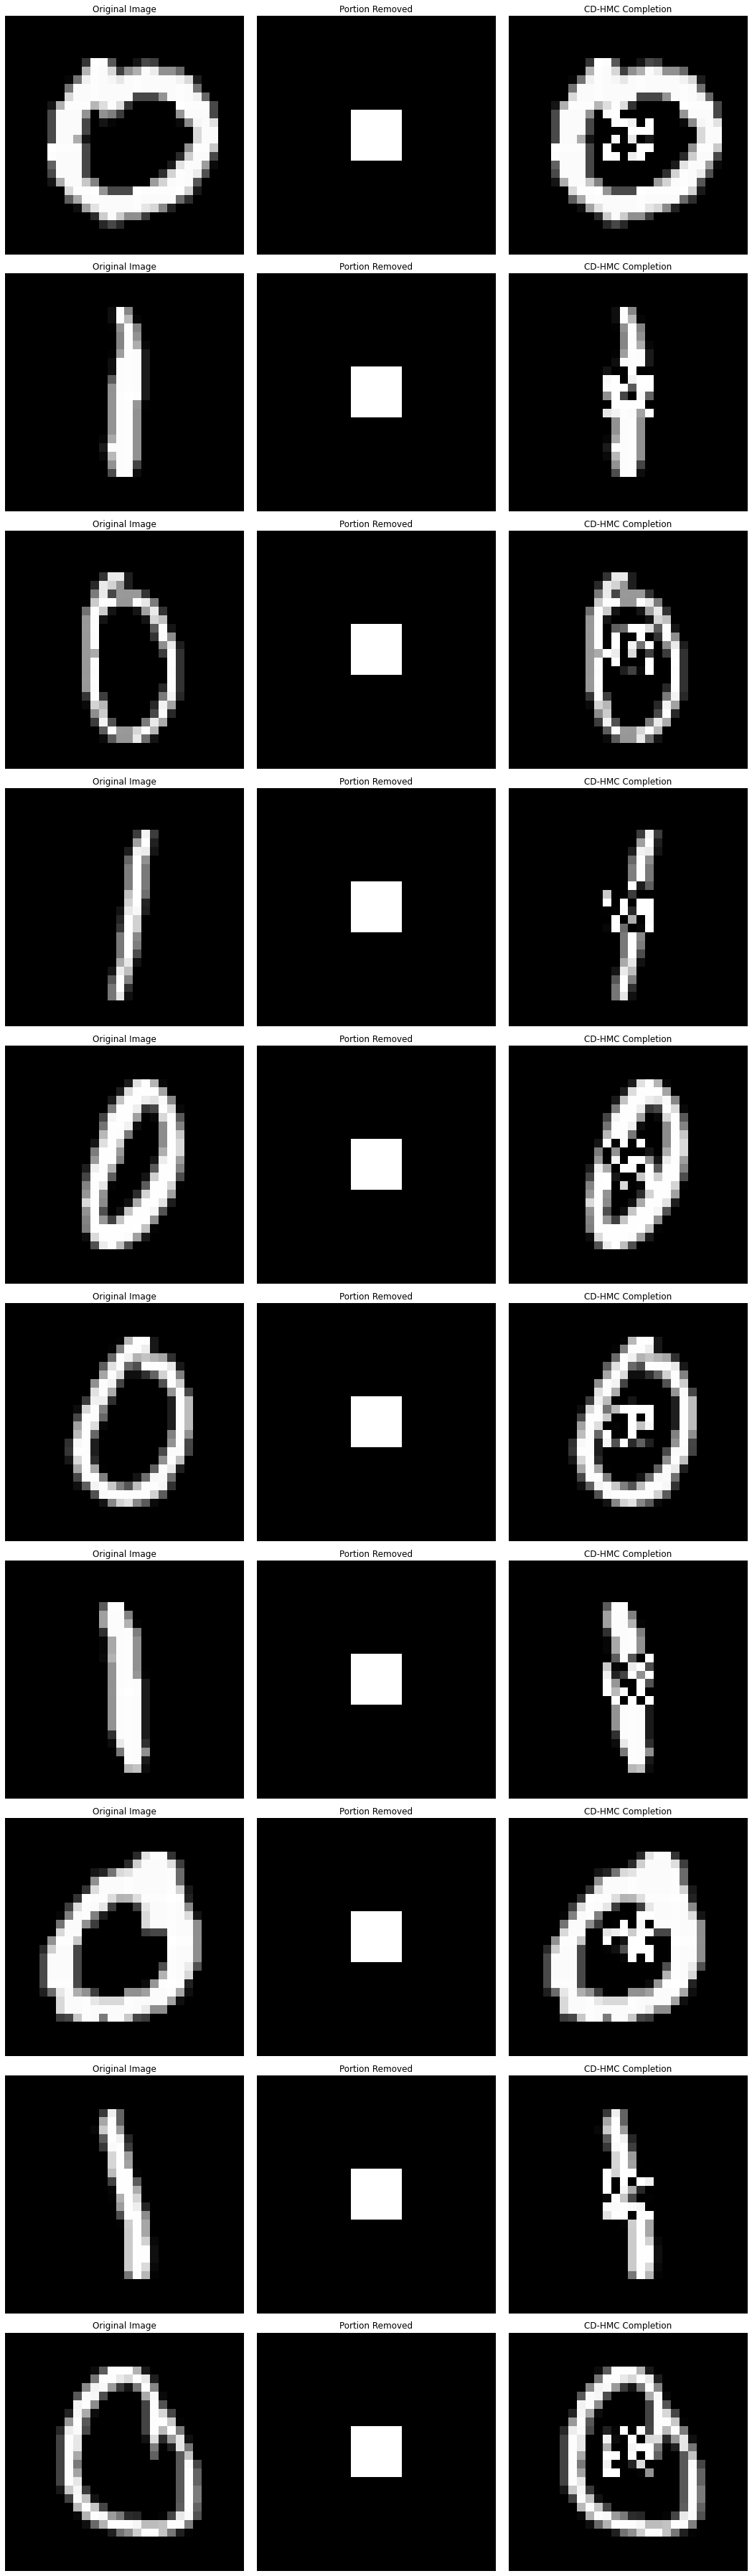

In [67]:
NUM_IMAGES = 10

fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(15, NUM_IMAGES * 5))

sigmoid = lambda x: 1 / (1 + np.exp(-x))

for IMG_NUM in range(NUM_IMAGES):

    fill_vals = sigmoid(newnet[0].numpy()[IMG_NUM])
    flat_mask = x_mask[0].flatten()
    #print('max is', filled_vals.max(), 'and min is', filled_vals.min())
    x_vals = images[IMG_NUM].numpy()
    
    x_filled = x_vals.copy()
    x_filled[flat_mask] = fill_vals

    ax[IMG_NUM, 0].imshow(x_vals.reshape((28, 28)), cmap='gray')
    ax[IMG_NUM, 1].imshow(x_mask[0], cmap='gray')
    ax[IMG_NUM, 2].imshow(x_filled.reshape((28, 28)), cmap='gray')
    ax[IMG_NUM, 0].set_title('Original Image')
    ax[IMG_NUM, 1].set_title('Portion Removed')
    ax[IMG_NUM, 2].set_title('CD-HMC Completion')
    ax[IMG_NUM, 0].axis('off')
    ax[IMG_NUM, 1].axis('off')
    ax[IMG_NUM, 2].axis('off')

plt.tight_layout()
plt.savefig('inpainting_no_extra_dims.pdf')
plt.show()